<a href="https://colab.research.google.com/github/Anonyo10/ML-projects/blob/main/ML_Project_Image_Classification(Version_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Enhancing Building Safety and Resilience Through Intelligent Management**
Sammy Cervantes, Anonyo Mitra, Kendrick McDonald, Luqman Sumartono & 
Andrew Trzcinski


In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Step 1: Importing libraries and load the image data from Gdrive (currently in two separate folder). We are using TensorFlow's ImageDataGenerator to preprocess the images and create data generators for training and validation data.

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Set the directories for the positive and negative samples
positive_dir = '/content/drive/MyDrive/ML project/External Images/cracks'
negative_dir = '/content/drive/MyDrive/ML project/External Images/no cracks'
merged_data_dir = '/content/drive/MyDrive/ML project/External Images'
test_data_dir = '/content/drive/MyDrive/ML project/External Images/test'

# Set the parameters for the image data generators
batch_size = 32
img_height = 150
img_width = 150


Step 2: We are splitting the data into training and validation sets to evaluate the model's performance on unseen data (we have used a 20% cut of the data here)

In [ ]:
# Create an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20)  # Using 20% of data for validation and test 

# Create training, validation, and test data generators
train_gen = datagen.flow_from_directory(
    merged_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

val_gen = datagen.flow_from_directory(
    merged_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

test_gen = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

Step 3: Here we build the CNN model using the Keras package. We have used a standard and basic architecture with a few convolutional and pooling layers, followed by a fully connected layer and an output layer (we can add more on the detail of this structure).

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

Rationale: We use
- a few Conv2D layers with increasing number of filters to extract features from the images.
- MaxPooling2D layers reduce the spatial dimensions of the feature maps.
- Flatten layer reshapes the feature maps into a one-dimensional vector.
- Dense layers are used to classify the features extracted by the convolutional layers.
- Dropout layer helps in reducing overfitting by randomly dropping some of the neurons during training.
- Sigmoid activation function in the output layer is used for binary classification.

Step 4: Now we are compiling the model before starting the training. We'll use binary_crossentropy loss for binary classification and the Adam optimizer (can add detail on what these are for after in the writeup).

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Step 5: Training the model using a training data generator and validateing it using the validation data generator.

In [ ]:
epochs = 25
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=len(val_gen))

Step 6: After training the model, we evaluate its performance on the test set and print the accuracy.

In [ ]:
loss, accuracy = model.evaluate(test_gen, steps=len(test_gen))
print(f"Test accuracy: {accuracy*100:.2f}%")

Step 7: Saving the models CNN

In [ ]:
model.save('crack_detection_model_google.h5')

Step 8: Loading the model and make predictions on the test set (from before)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the saved model
loaded_model = load_model('crack_detection_model_google.h5')

# Load and preprocess a new image for prediction
image_path = '/content/drive/MyDrive/ML Data/Positive/00322.jpg'
image = load_img(image_path, target_size=(img_height, img_width))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)

# Make a prediction
prediction = loaded_model.predict(image)

if prediction > 0.5:
    print("The model predicts the image has a crack.")
else:
    print("The model predicts the image doesn't have a crack.")

In [ ]:
print("Class indices:", train_gen.class_indices)

Step 9: Plotting training and validation accuracy and loss

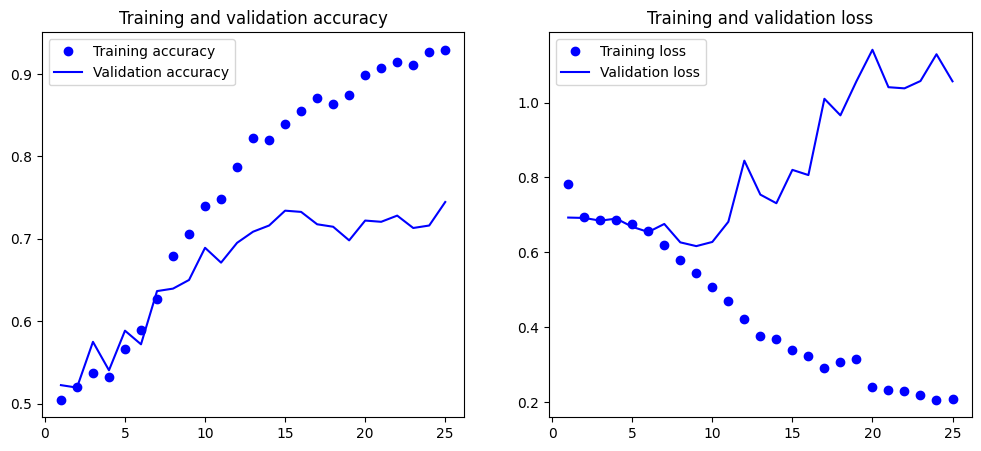

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)


Step 10: Displaying a sample images with predictions (here we are writing a function to highlight the detected crack regions in the images using the OpenCV library)

In [ ]:
import cv2

def highlight_cracks(image, prediction):
    highlighted_image = image.copy()
    if prediction < 0.5:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, threshold = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w * h > 100:  # Filter out small regions
                cv2.rectangle(highlighted_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    return highlighted_image


Step 11: Displaying sample images with their respective predictions and highlighted regions. (This takes a random set of images from the validation set and their true labels and the model's predictions. The detected crack regions are highlighted with green rectangles) 

n.b the `highlight_cracks` function may not perfectly identify crack regions, but it should give a rough indication of the areas the model is focusing on. Here ive tried tensorflows gradcam for visualiing the CNN image identification

In [ ]:

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from sklearn.preprocessing import MinMaxScaler

import os
import random

# Load images and labels
positive_images, positive_labels = load_images(positive_dir, positive_labels_dir)
negative_images, negative_labels = load_images(negative_dir, negative_labels_dir)

# Combine positive and negative images and labels
images = np.concatenate((positive_images, negative_images))
labels = np.concatenate((positive_labels, negative_labels))

# Get random images
random_images, random_labels = random_images_subset(images, labels, n_samples)


def load_images(image_folder, label_folder, num_samples=None):
    image_files = os.listdir(image_folder)
    
    if num_samples:
        image_files = random.sample(image_files, num_samples)
    
    images = []
    labels = []
    
    for file in image_files:
        img = cv2.imread(os.path.join(image_folder, file))
        img = cv2.resize(img, (150, 150))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label_file = file.replace(".jpg", ".txt")
        with open(os.path.join(label_folder, label_file), "r") as f:
            label = int(f.read().strip())
        
        images.append(img)
        labels.append(label)
    
    return np.array(images), np.array(labels)


# Function to randomly select a subset of images
def random_images_subset(images, labels, n_samples):
    indices = np.random.permutation(len(images))[:n_samples]
    return images[indices], labels[indices]

# Set the number of random images you want to visualize
n_samples = 5

# Get random images
random_images, random_labels = random_images_subset(images, labels, n_samples)

# Define a loss function for Grad-CAM
def loss(output):
    label_index = tf.argmax(output[0])
    return (output[0][label_index],)

# Create a Saliency object with the model
saliency = Saliency(model)

# Plot the original images and Grad-CAM heatmaps
fig, axes = plt.subplots(nrows=n_samples, ncols=2, figsize=(10, n_samples * 5))

scaler = MinMaxScaler()

for i, (image, label) in enumerate(zip(random_images, random_labels)):
    # Compute the heatmap using the Saliency object and the loss function
    heatmap = saliency(loss, image[np.newaxis, ...])
    heatmap = normalize(heatmap)
    
    # Scale the image to the range [0, 1]
    image = scaler.fit_transform(image.reshape(-1, 1)).reshape(image.shape)
    
    # Plot original image
    axes[i, 0].imshow(image)
    axes[i, 0].set_title(f"Label: {label}")
    axes[i, 0].axis('off')
    
    # Plot Grad-CAM heatmap
    axes[i, 1].imshow(image, alpha=0.7)
    axes[i, 1].imshow(heatmap[0], cmap='jet', alpha=0.3)  
    axes[i, 1].set_title("Grad-CAM heatmap")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


21/21 [==============================] - 27s 1s/step


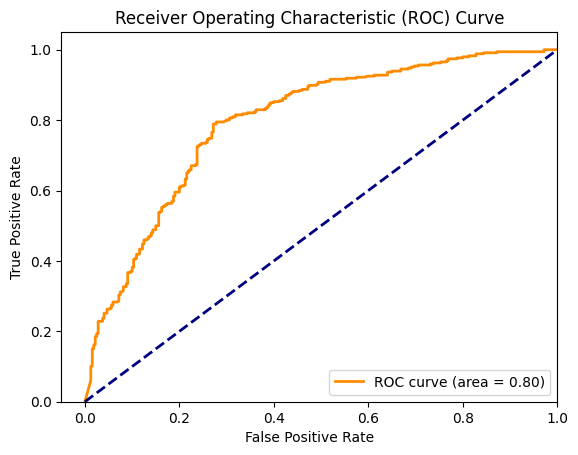

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc

# Collect true labels and predicted probabilities from the validation generator
val_labels = np.concatenate([val_gen[i][1] for i in range(len(val_gen))])
val_predictions = model.predict(val_gen)

# Calculate the FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(val_labels, val_predictions)

# Compute the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.xlim([-0.05, 1.0])  # Add a 5% margin to the left side
plt.show()